In [29]:
import maboss
from tqdm import tqdm
import os
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

work_dir = '/home/spankaew/Git/BooleanBenchmark/'
model_name = 'bonesis_tutorial'

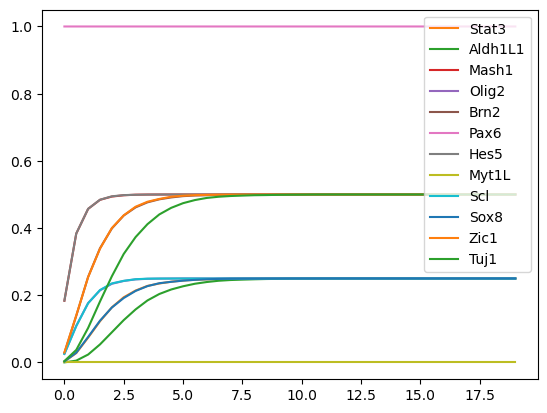

In [2]:
model = maboss.loadBNet('/home/spankaew/Git/BooleanBenchmark/models/test_bonesis/bn1.bnet')
model.network.set_istate('Pax6',[0,1])
model.update_parameters(max_time = 20)
simulation = model.run()
simulation.plot_node_trajectory()

In [3]:
# Create blank file to get the results
ensemble_results = {}

# Set model path
path = '/home/spankaew/Git/BooleanBenchmark/models/test_bonesis/' 
model_list = os.listdir(path)

# Get node list
node_list = list(model.network.names)
node_list.remove('Pax6')

for model in tqdm(model_list):

    # Load model
    simulations = maboss.loadBNet(path + model)

    # Setup the model initial condition
    ## Put all inputs at random
    simulations.network.set_istate('Pax6',[0,1])
    for i in node_list:
        simulations.network.set_istate(i,[1,0])
        
    # Modify the parameter of the model
    simulations.update_parameters(sample_count = 10000,
                                  thread_count = 15,
                                  max_time = 20,
                                  time_tick = 1)
    simulations.network.set_output(simulations.network.names)

    # Perform simulations
    result = simulations.run()

    # Get matrix
    model_mtx = result.get_nodes_probtraj().copy()

    # Setup cell matrix
    ## Cells
    model_mtx['model_id'] = model.replace('.bnet','')
    ## Timepoint
    model_mtx['timepoint'] = model_mtx.index
    ## Change index
    model_mtx.index = model_mtx.index.map(str)
    model_mtx.index = model + '_' + model_mtx.index

    # Concatenate model results in dictionary
    ensemble_results[model] = model_mtx

import pandas as pd
simulation_df = pd.concat(ensemble_results.values(), ignore_index = True)
simulation_df.to_csv('/home/spankaew/Git/BooleanBenchmark/simulation_files/test_bonesis_simulation.csv')

100%|██████████| 88/88 [00:07<00:00, 11.24it/s]


In [4]:
cl_df = pd.read_csv('/home/spankaew/Git/BooleanBenchmark/simulation_files/test_bonesis_simulation.csv', index_col = 0)
cl_df.index = cl_df.model_id + '_' + [str(f) for f in cl_df.timepoint]
cl_df.index.name = None

In [5]:
adata = sc.AnnData(cl_df.drop(['model_id','timepoint'],axis = 1))
adata.obs['timepoint'] = cl_df['timepoint']
adata.obs['model_id'] = cl_df['model_id']

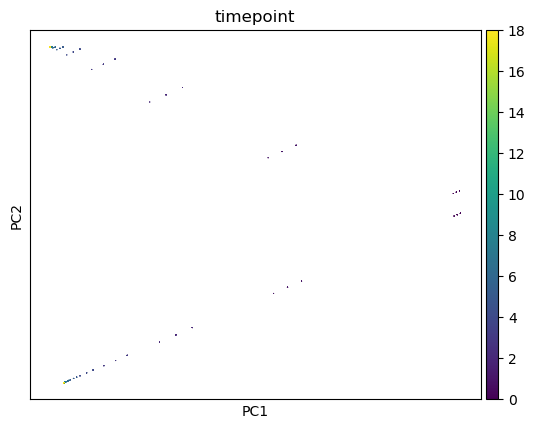

In [6]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color = 'timepoint', size = 2)

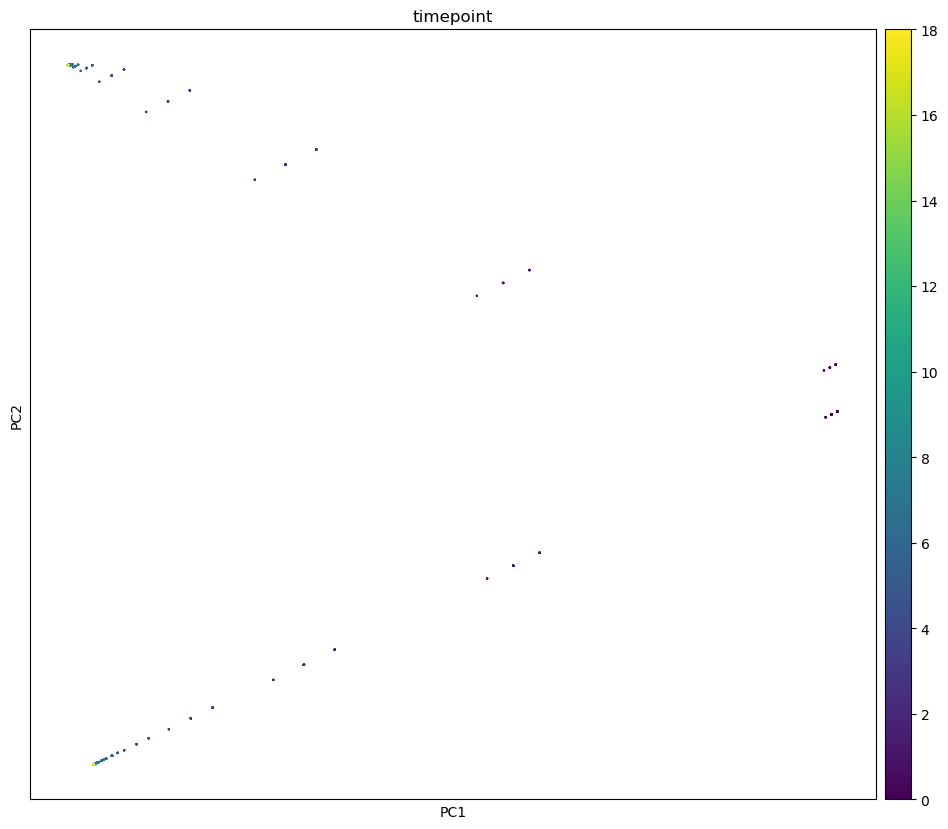

In [8]:
from matplotlib.pyplot import rc_context
with rc_context({"figure.figsize": (12, 10)}):
    sc.pl.pca(adata, color = 'timepoint', size = 10)

In [9]:
pca_mat = [array[:2] for array in adata.obsm['X_pca']]
pca_mat = pd.DataFrame(pca_mat, columns= ['pca1','pca2'])
pca_mat.index = adata.obs.index
pca_mat = pd.concat([pca_mat, adata.obs], axis = 1,ignore_index = False)

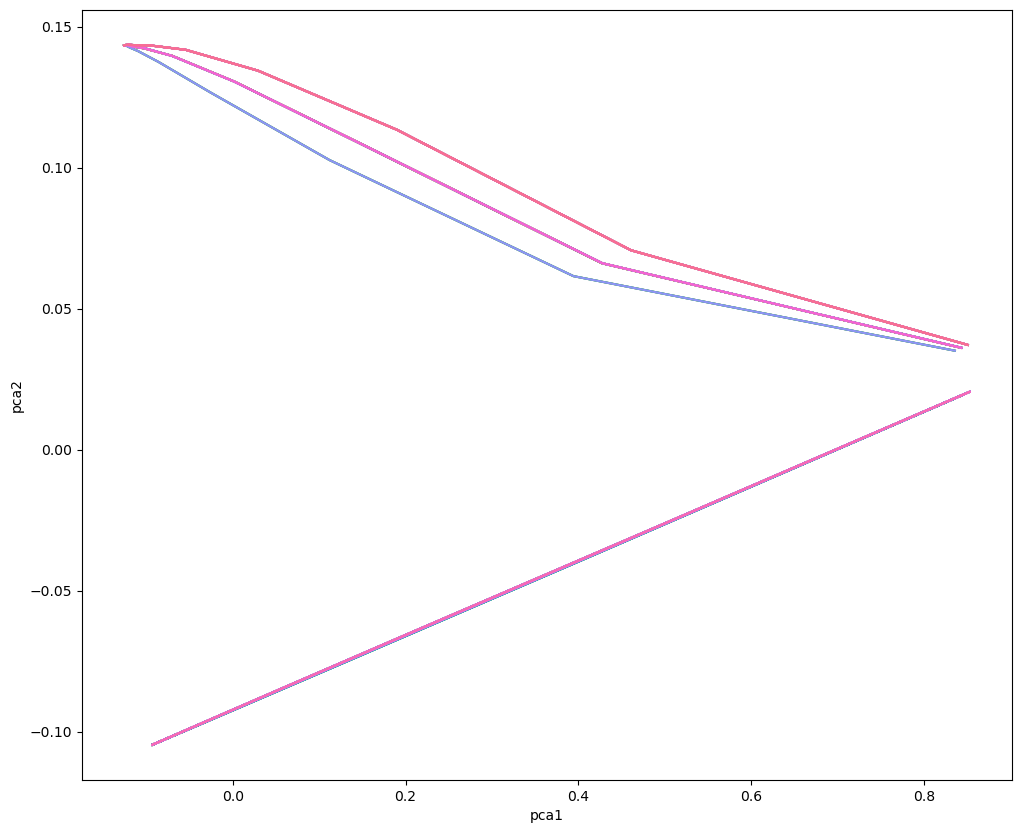

In [10]:
import seaborn as sns
with rc_context({"figure.figsize": (12, 10)}):
    plot = sns.lineplot(data = pca_mat, x = 'pca1',y='pca2',hue = 'model_id', sort = False)
    plot.get_legend().remove()

plt.show()

# Trajectory comparison using single variable from PCA

In [11]:
import tslearn
from tslearn.datasets import CachedDatasets
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.preprocessing import TimeSeriesResampler
import numpy


seed = 0
numpy.random.seed(seed)

Euclidean k-means
0.003 --> 0.002 --> 0.002 --> 


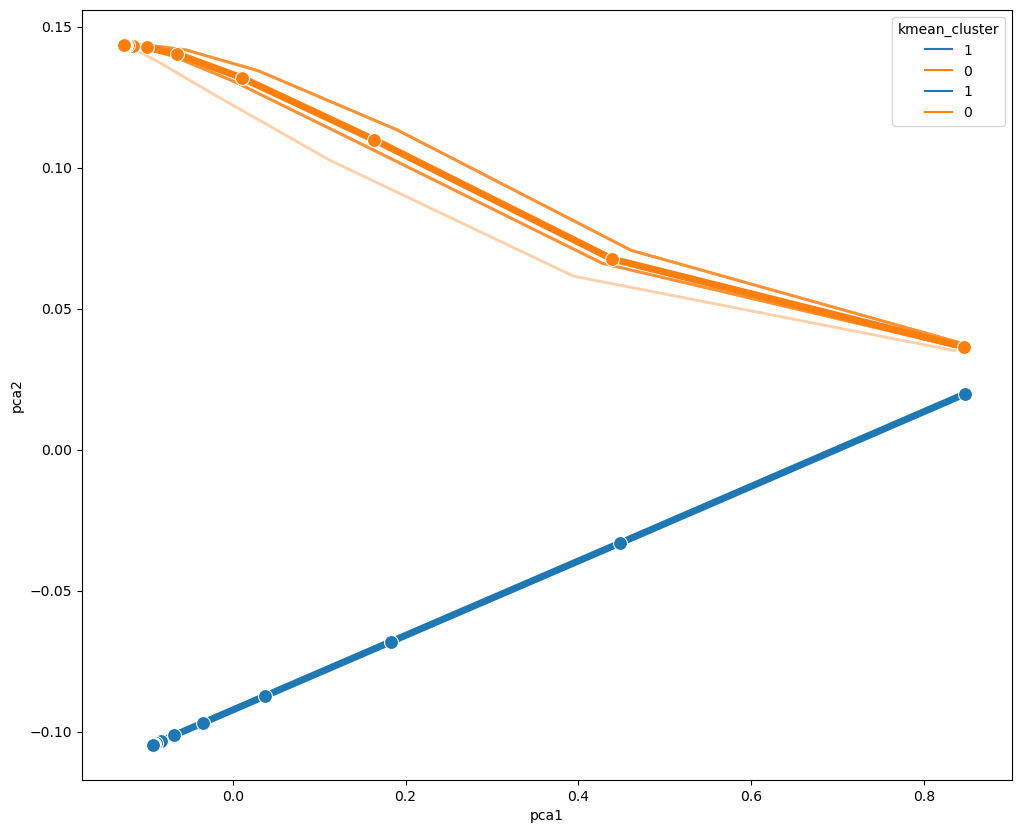

In [12]:
model_name = pca_mat.model_id.cat.categories

model_pca_all = {}
for i in model_name:
    model_pca = pca_mat.loc[pca_mat.model_id == i,['pca1','pca2']].values
    model_pca_all[i] = numpy.array(model_pca)

pca_all_trajectory = numpy.array(list(model_pca_all.values()))

# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=2, verbose=True, random_state=seed)
y_pred = km.fit_predict(pca_all_trajectory)


# Plot the trajectory
cluster_dict = dict(zip(list(model_name),list(y_pred)))
pca_mat['kmean_cluster'] = pca_mat['model_id']
pca_mat['kmean_cluster'] = pca_mat['kmean_cluster'].replace(cluster_dict)

## Calculate the mean position
kmean_cluster = pca_mat.groupby(['timepoint','kmean_cluster'])[['pca1','pca2']].mean()

## Plot with Seaborn
import seaborn as sns
with rc_context({"figure.figsize": (12, 10)}):
    plot = sns.lineplot(data = pca_mat, 
                        x = 'pca1',y='pca2',
                        hue = 'kmean_cluster', units = 'model_id', estimator = None, lw=2, alpha = .1,
                        sort = False)
    plot.get_legend().remove()

    plot2 = sns.lineplot(data = kmean_cluster, 
                        x = 'pca1',y='pca2',
                        hue = 'kmean_cluster',
                        sort = False, marker = 'o', linewidth = 5, markersize = 10)

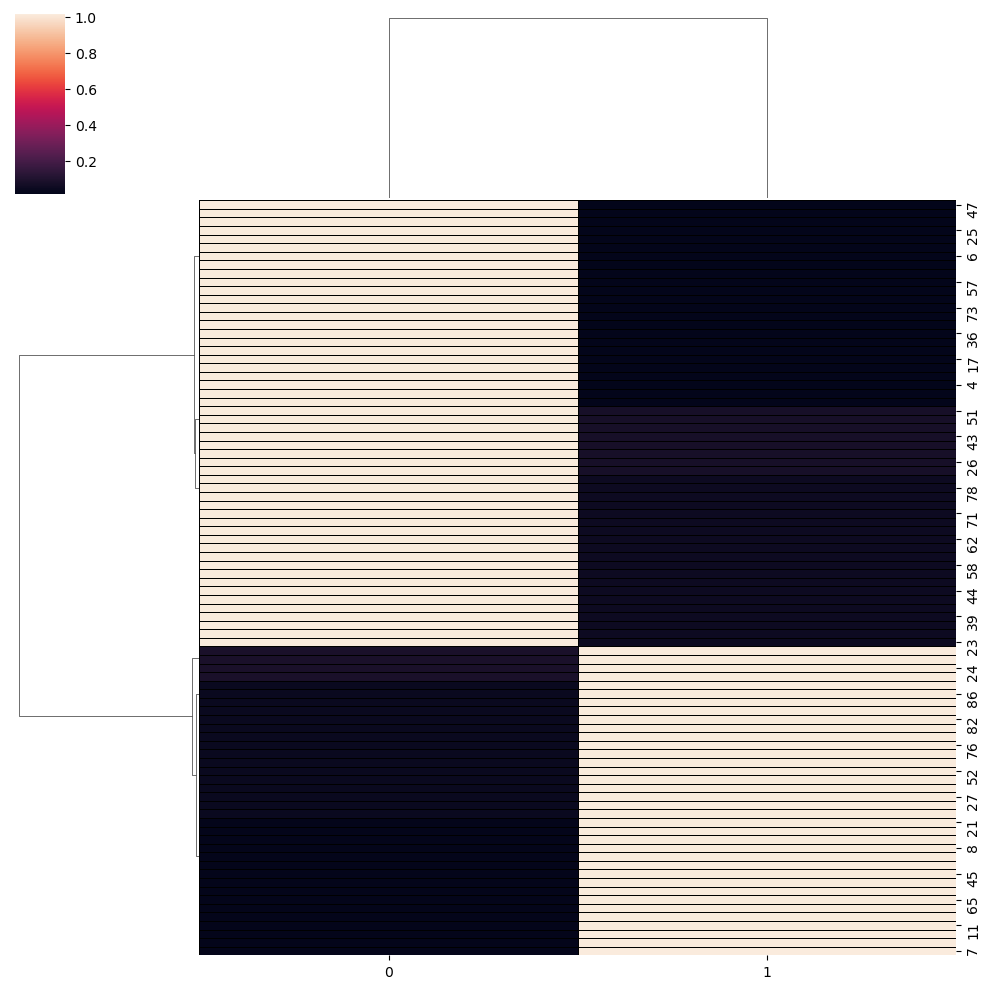

In [15]:
distance_space = km.transform(pca_all_trajectory)
distance_space = pd.DataFrame(distance_space)
sns.clustermap(distance_space, linewidth =.5, linecolor = 'black')

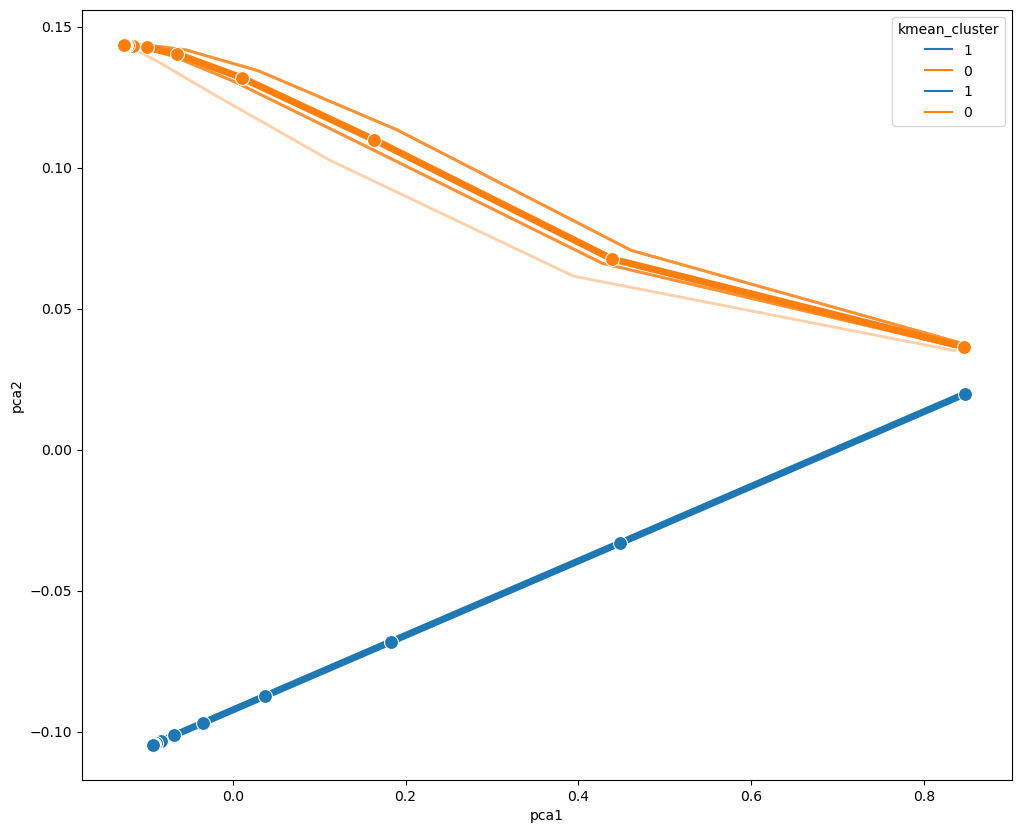

In [27]:
## Plot with Seaborn
import seaborn as sns
with rc_context({"figure.figsize": (12, 10)}):
    plot = sns.lineplot(data = pca_mat, 
                        x = 'pca1',y='pca2',
                        hue = 'kmean_cluster', units = 'model_id', estimator = None, lw=2, alpha = .1,
                        sort = False)
    plot.get_legend().remove()

    plot2 = sns.lineplot(data = kmean_cluster, 
                        x = 'pca1',y='pca2',
                        hue = 'kmean_cluster',
                        sort = False, marker = 'o', linewidth = 5, markersize = 10)

In [30]:
pd.Series(cluster_dict).to_csv(work_dir + 'simulation_files/test_bonesis_cluster.csv')

- Find mean PCA postion for each clusters 

- Find mean Euclidean distance at each timestpes between clusters

In [17]:
kmean_dist = pca_mat.groupby(['timepoint','kmean_cluster'])['pca1'].mean()
kmean_dist = pd.DataFrame(kmean_dist).pivot_table(values = 'pca1', index=  'timepoint', columns = 'kmean_cluster')

In [29]:
# Get the list of files in the model folder
model_folder = '/home/spankaew/Git/BooleanBenchmark/models/test_bonesis/'
model_files = os.listdir(model_folder)

model_logic = pd.DataFrame()

for i in model_files:
    logic = pd.read_csv(model_folder + i, index_col=0, header = None)
    logic.columns = [i.split('.')[0]]
    model_logic = pd.concat([model_logic, logic], axis = 1, ignore_index=False)
model_logic.index.name = None
model_logic = model_logic.transpose()

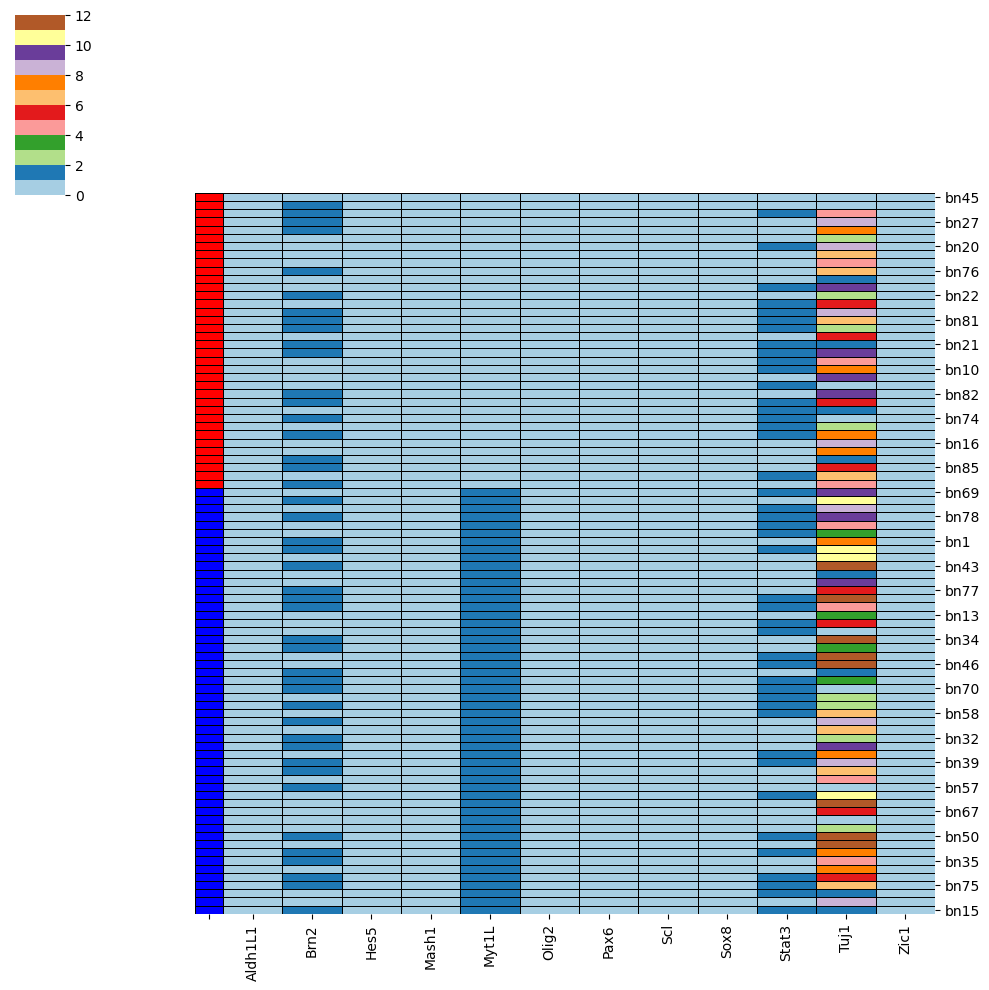

In [32]:
model_logic_categorical = model_logic.copy()
for i in model_logic_categorical.columns:
    model_logic_categorical[i], _ = pd.factorize(model_logic[i])



# Create cluster color palette
kmean_index = pd.Series(model_logic.index, index = model_logic.index)
kmean_index = kmean_index.replace(cluster_dict)
lut = dict(zip(kmean_index.unique(), "rbg"))
row_colors = kmean_index.map(lut)

sort_index = list(kmean_index.sort_values().index)

# Plot clustermap
sns.clustermap(model_logic_categorical.loc[sort_index],
            row_colors = row_colors[sort_index], 
            row_cluster=False,
            col_cluster = False,
            linecolor = 'black', linewidth = .5, 
            cmap = 'Paired')

In [83]:
model_logic.Myt1L.value_counts()

Myt1L
 0        52
 Olig2    36
Name: count, dtype: int64

# Visualizing different states in the model

In [ ]:
# Create blank file to get the results
ensemble_results = {}

# Set model path
path = '/home/spankaew/Git/BooleanBenchmark/models/test_bonesis/' 
model_list = os.listdir(path)

# Get node list
node_list = list(model.network.names)
node_list.remove('Pax6')

for model in tqdm(model_list):

    # Load model
    simulations = maboss.loadBNet(path + model)

    # Setup the model initial condition
    ## Put all inputs at random
    simulations.network.set_istate('Pax6',[0,1])
    for i in node_list:
        simulations.network.set_istate(i,[1,0])
        
    # Modify the parameter of the model
    simulations.update_parameters(sample_count = 10000,
                                  thread_count = 15,
                                  max_time = 20,
                                  time_tick = 1)
    simulations.network.set_output(simulations.network.names)

    # Perform simulations
    result = simulations.run()

    # Get matrix
    model_mtx = result.get_states_probtraj().copy()

    # Setup cell matrix
    ## Cells
    model_mtx['model_id'] = model.replace('.bnet','')
    ## Timepoint
    model_mtx['timepoint'] = model_mtx.index
    ## Change index
    model_mtx.index = model_mtx.index.map(str)
    model_mtx.index = model + '_' + model_mtx.index

    # Concatenate model results in dictionary
    ensemble_results[model] = model_mtx

import pandas as pd
simulation_df = pd.concat(ensemble_results.values(), ignore_index = True)
simulation_df.to_csv('/home/spankaew/Git/BooleanBenchmark/tmp/test_bonesis_StateSimulation.csv')

100%|██████████| 88/88 [00:07<00:00, 11.07it/s]


In [70]:
state_df = pd.read_csv('/home/spankaew/Git/BooleanBenchmark/tmp/test_bonesis_StateSimulation.csv', index_col = 0)
state_df.index = state_df.model_id + '_' + [str(f) for f in state_df.timepoint]
state_df.index.name = None

In [71]:
state_df['kmean_cluster'] = state_df['model_id'].replace(cluster_dict)
state_df = state_df.drop('model_id',axis = 1)
state_df = state_df.groupby(['kmean_cluster','timepoint']).mean()
state_df = state_df.replace({numpy.nan:0})

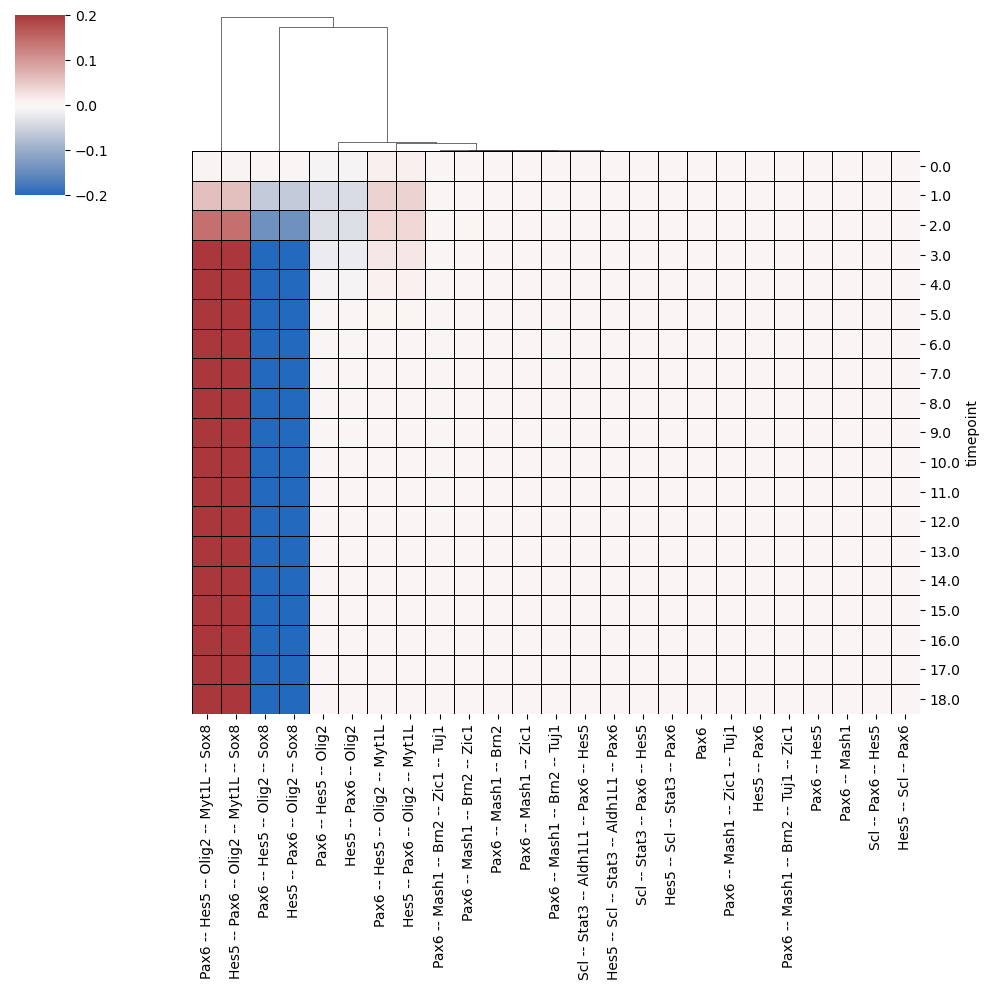

In [79]:
sns.clustermap(state_df.loc[0] - state_df.loc[1], row_cluster=False, cmap = 'vlag', vmax = .2, vmin = -.2, linecolor = 'black', linewidth = .5)